In [1]:
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing

import numpy as np
import matplotlib.pyplot as plt
import string
import pathlib

In [9]:
charset = ''.join([
    string.ascii_lowercase,
#     string.ascii_uppercase,
#     string.digits,
#     string.punctuation,
    ' '
])

In [4]:
data_url = 'https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz'
dataset_dir = utils.get_file(
    'so_text_dataset',
    origin=data_url,
    untar=True,
    cache_dir='stack_overflow',
    cache_subdir='')

In [5]:
dataset_dir = pathlib.Path(dataset_dir).parent

In [6]:
dataset_dir

WindowsPath('/tmp/.keras')

In [7]:
raw_train_ds = preprocessing.text_dataset_from_directory(
    dataset_dir/'train',
    batch_size=1,
    validation_split=0.2,
    subset='training',
    seed=42)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [10]:
def one_hot(text):
    s = '[SEP]'
#     encoded = tf.keras.preprocessing.text.one_hot(
#         s.join(text),
#         len(charset),
#         filters='\t\n',
#         lower=False, split=s
#     )
    text = text.lower()
    encoded = []
    for c in text:
        if c in charset:
            encoded.append(charset.index(c))
        else:
            encoded.append(charset.index(' '))
    encoded = tf.one_hot(encoded, len(charset))
    return encoded

one_hot('test data')

<tf.Tensor: shape=(9, 27), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
    

In [26]:
def prep_data(x):
    x = x.numpy().decode('UTF-8')
    x = x[:50]
    c = one_hot(x + ' ' * (50 - len(x)))
    return c

In [116]:
def preprocess(n=250):
    text_data = []
    for a, b in raw_train_ds.take(n):
    #     print(len(a), len(b))
    #     for i in range(5):
    #         print(a[i])
    #         print(b[i])
    #     print(a[0].numpy().decode('ascii'))
        text_data.append(prep_data(a[0]).numpy())
    text_data = np.stack(text_data)
    return text_data

In [29]:
text_data.shape

(100, 50, 27)

In [432]:
num_chars = len(charset)
model = tf.keras.models.Sequential()

encoder_shape = []

encoder_layers = [
    layers.LSTM(10, input_shape=(50, num_chars,), activation='tanh', return_sequences=True),
    layers.LSTM(10, input_shape=(50, num_chars,), activation='tanh', return_sequences=False),
    layers.Dense(5, activation='tanh'),
    layers.Dense(2, activation='tanh')
]
decoder_layers = [
    layers.Dense(4, activation='tanh'),
    layers.RepeatVector(50),
    layers.Dense(10, activation='tanh'),
    layers.LSTM(num_chars, return_sequences=True, activation='tanh'),
]
for l in encoder_layers + decoder_layers:
    model.add(l)

# model.summary()

In [433]:
def decode(t):
    return ''.join(charset[int(np.clip(0, len(charset)-1, i))] for i in tf.argmax(t[0], axis=1))

def run_encoder(pred):
    for l in encoder_layers:
        pred = l(pred)
    return pred

def sample():
    noise = np.random.uniform(0, 1, [1, 2])
    pred = noise
    for l in decoder_layers:
        pred = l(pred)
    y = decode(pred)
    return y

f = sample()
print(f, len(f))
# reconstruct()

jjjjjllllqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq 50


In [434]:
model(text_data)

<tf.Tensor: shape=(1000, 50, 27), dtype=float32, numpy=
array([[[ 5.99369360e-03, -2.52126437e-03,  9.52605903e-03, ...,
          4.59741335e-03, -2.17207032e-03,  3.39268649e-04],
        [ 1.02015305e-02, -3.77408531e-03,  1.65513046e-02, ...,
          8.17200635e-03, -3.63327703e-03,  2.52650847e-04],
        [ 1.30753918e-02, -4.19575162e-03,  2.17463411e-02, ...,
          1.10618109e-02, -4.64696018e-03,  1.77452857e-05],
        ...,
        [ 1.53816529e-02, -6.52547518e-04,  3.48177925e-02, ...,
          2.34297365e-02, -9.32294037e-03,  1.76843349e-03],
        [ 1.53821986e-02, -6.53189316e-04,  3.48168388e-02, ...,
          2.34300252e-02, -9.32280906e-03,  1.76893536e-03],
        [ 1.53826550e-02, -6.53709751e-04,  3.48160565e-02, ...,
          2.34303009e-02, -9.32269823e-03,  1.76934188e-03]],

       [[-2.87705031e-03,  1.44765945e-03, -3.09131178e-03, ...,
         -1.87631929e-03,  5.04375726e-04,  3.99514625e-04],
        [-4.84738313e-03,  2.33318005e-03, -5.3

In [445]:
model.compile(
    tf.keras.optimizers.Adam(learning_rate=0.001),
    losses.mean_squared_error
#     loss=tf.edit_distance
)

In [443]:
text_data = preprocess(1000)

In [ ]:
history = model.fit(text_data, text_data, epochs=100)

In [88]:
import tensorflow.python.ops.numpy_ops.np_config as npcfg
npcfg.enable_numpy_behavior()

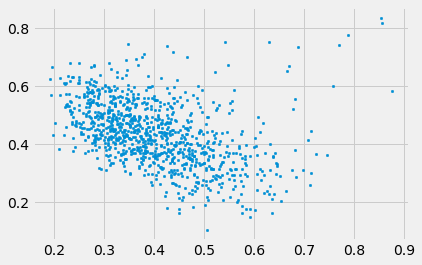

In [441]:
# import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
# text_data = preprocess(1000)
plt.scatter(*run_encoder(text_data).T, alpha=1, s=6)
plt.show()

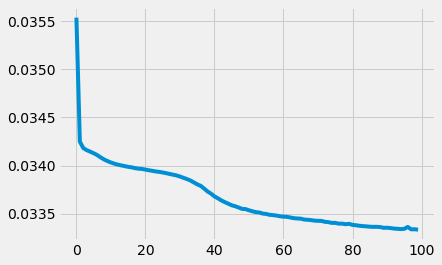

In [438]:
plt.plot(history.history['loss'])

In [439]:
def reconstruct():
    return decode(model(text_data))
    
reconstruct()

' hoa t                                            '

In [440]:
for x in range(10):
    print(sample())

 ho                                               
 ho                                               
 ho                                               
 hoe teeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
 heeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
 ho                                               
 ho                                               
 hoa n                                            
 blannnn ninnnnnnnnnnnnnnnnnniiiii                
 boa n                                            
